In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [3]:
import paddle
import numpy as np
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.hamiltonian import Hamiltonian
from paddle_quantum.loss import ExpecVal
import matplotlib.pyplot as plt
import matplotlib

paddle_quantum.set_backend("state_vector")

In [29]:
def U_WZW(train_block, w_theta, x):
    cir = Circuit(1)
    for i in range(train_block):
        cir.rz(0, param=w_theta[i][1])
        cir.ry(0, param=w_theta[i][0])
        cir.rz(0, param=x) 
    cir.rz(0, param=w_theta[-1][1])
    cir.ry(0, param=w_theta[-1][0])
    return cir

In [75]:
def target_func(x):
    return (1+np.sin(np.pi * x))/2


def get_data():
    x_plot = np.arange(0, np.pi, 5/1000)
    y_plot = target_func(x_plot)

    np.random.seed(0)
    x_all = np.random.uniform(0, np.pi, 500)

    y_all = target_func(x_all)

    x_train, y_train = x_all[:400], y_all[:400]
    x_test,y_test = x_all[400:], y_all[400:]

    return x_train, y_train,x_test,y_test, x_plot, y_plot


x_train, y_train, x_test,y_test,x_plot, y_plot = get_data()

In [85]:
class QNN(paddle.nn.Layer):
    def __init__(self, 
                 train_block,          
                 SEED=0,
                 dtype='float64'):
        super(QNN, self).__init__()
        self.train_block = train_block
        paddle.seed(SEED)
       
        self.w_theta = self.create_parameter(
            shape=[(train_block+1), 2],
            default_initializer=paddle.nn.initializer.Uniform(0.0, 2*np.pi),
            dtype=dtype,
            is_bias=False)


    def forward(self, x):
        """
        Forward propagation
        """
        predict = []
        H = Hamiltonian([(1.0, "z0")])
        out_func = ExpecVal(H)
        x = paddle.to_tensor(x, dtype='float64')
        if len(x.shape) == 1:  
            x = x.reshape((-1, 1))
        for i in range(x.shape[0]):
            cir = U_WZW(self.train_block, self.w_theta, x[i])
            out_state = cir()
            print(x[i],out_func(out_state),cir)
            predict.append(out_func(out_state))
        return paddle.concat(predict).reshape((-1,)), cir



def train_qnn(x, y, train_block, LR, ITR, SEED, BATCHSIZE=40):
    model = QNN(train_block, SEED)
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=model.parameters())
    loss_list = []
    x = paddle.to_tensor(x, dtype='float64')
    y = paddle.to_tensor(y, dtype='float64')
    for ep in range(1, ITR + 1):
        for itr in range(len(x) // BATCHSIZE):
            x_batch = x[itr * BATCHSIZE:(itr + 1) * BATCHSIZE]
            y_batch = y[itr * BATCHSIZE:(itr + 1) * BATCHSIZE]
            predict, cir = model(x_batch)
            avg_loss = paddle.mean((predict - y_batch) ** 2)
            loss_list.append(avg_loss.numpy())
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_grad()
            if (itr+1) % 5 == 0:
                print("qnn:epoch:", ep,"qnn:iter:", (itr+1), " train  loss:", "%.8f" % avg_loss.numpy())


    return model, loss_list

In [86]:
SEED = 2
QITR = 5
QLR = 0.1
train_block = 5
model, loss_list = train_qnn(x_train, y_train, train_block=train_block, LR=QLR, ITR=QITR, SEED=SEED)
predict = model(x_test)

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.72414847]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.33261794]) --Rz(3.734)----Ry(4.748)----Rz(1.724)----Rz(5.220)----Ry(2.073)----Rz(1.724)----Rz(1.891)----Ry(2.498)----Rz(1.724)----Rz(1.742)----Ry(0.488)----Rz(1.724)----Rz(5.150)----Ry(4.178)----Rz(1.724)----Rz(1.429)----Ry(3.051)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.24683366]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [-0.43700340]) --Rz(3.734)----Ry(4.748)----Rz(2.247)----Rz(5.220)----Ry(2.073)----Rz(2.247)----Rz(1.891)----Ry(2.498)----Rz(2.247)----Rz(1.742)----Ry(0.488)----Rz(2.247)----Rz(5.150)----Ry(4.178)----R

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.73322377]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [-0.36654440]) --Rz(3.734)----Ry(4.748)----Rz(2.733)----Rz(5.220)----Ry(2.073)----Rz(2.733)----Rz(1.891)----Ry(2.498)----Rz(2.733)----Rz(1.742)----Ry(0.488)----Rz(2.733)----Rz(5.150)----Ry(4.178)----Rz(2.733)----Rz(1.429)----Ry(3.051)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.07442019]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.04495549]) --Rz(3.734)----Ry(4.748)----Rz(3.074)----Rz(5.220)----Ry(2.073)----Rz(3.074)----Rz(1.891)----Ry(2.498)----Rz(3.074)----Rz(1.742)----Ry(0.488)----Rz(3.074)----Rz(5.150)----Ry(4.178)----R

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\dygraph\math_op_patch.py:276: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.float64, the right dtype will convert to paddle.float32
  warnings.warn(


Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.12942738]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.93486673]) --Rz(3.689)----Ry(4.848)----Rz(1.129)----Rz(5.320)----Ry(2.173)----Rz(1.129)----Rz(1.991)----Ry(2.398)----Rz(1.129)----Rz(1.642)----Ry(0.388)----Rz(1.129)----Rz(5.250)----Ry(4.078)----Rz(1.129)----Rz(1.529)----Ry(3.151)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.37297638]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.87989938]) --Rz(3.689)----Ry(4.848)----Rz(1.373)----Rz(5.320)----Ry(2.173)----Rz(1.373)----Rz(1.991)----Ry(2.398)----Rz(1.373)----Rz(1.642)----Ry(0.388)----Rz(1.373)----Rz(5.250)----Ry(4.078)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.06192022]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.06324431]) --Rz(3.689)----Ry(4.848)----Rz(2.062)----Rz(5.320)----Ry(2.173)----Rz(2.062)----Rz(1.991)----Ry(2.398)----Rz(2.062)----Rz(1.642)----Ry(0.388)----Rz(2.062)----Rz(5.250)----Ry(4.078)----Rz(2.062)----Rz(1.529)----Ry(3.151)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.43411454]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.03542918]) --Rz(3.689)----Ry(4.848)----Rz(0.434)----Rz(5.320)----Ry(2.173)----Rz(0.434)----Rz(1.991)----Ry(2.398)----Rz(0.434)----Rz(1.642)----Ry(0.388)----Rz(0.434)----Rz(5.250)----Ry(4.078)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.99897362]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.96617979]) --Rz(3.625)----Ry(4.947)----Rz(0.999)----Rz(5.420)----Ry(2.270)----Rz(0.999)----Rz(1.971)----Ry(2.302)----Rz(0.999)----Rz(1.707)----Ry(0.303)----Rz(0.999)----Rz(5.345)----Ry(3.983)----Rz(0.999)----Rz(1.601)----Ry(3.129)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.30144558]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.87533867]) --Rz(3.625)----Ry(4.947)----Rz(1.301)----Rz(5.420)----Ry(2.270)----Rz(1.301)----Rz(1.971)----Ry(2.302)----Rz(1.301)----Rz(1.707)----Ry(0.303)----Rz(1.301)----Rz(5.345)----Ry(3.983)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.84825506]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.89768195]) --Rz(3.625)----Ry(4.947)----Rz(0.848)----Rz(5.420)----Ry(2.270)----Rz(0.848)----Rz(1.971)----Ry(2.302)----Rz(0.848)----Rz(1.707)----Ry(0.303)----Rz(0.848)----Rz(5.345)----Ry(3.983)----Rz(0.848)----Rz(1.601)----Ry(3.129)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.30968014]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.11252066]) --Rz(3.625)----Ry(4.947)----Rz(2.310)----Rz(5.420)----Ry(2.270)----Rz(2.310)----Rz(1.971)----Ry(2.302)----Rz(2.310)----Rz(1.707)----Ry(0.303)----Rz(2.310)----Rz(5.345)----Ry(3.983)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.27845352]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.33279932]) --Rz(3.595)----Ry(5.040)----Rz(2.278)----Rz(5.511)----Ry(2.354)----Rz(2.278)----Rz(1.963)----Ry(2.208)----Rz(2.278)----Rz(1.765)----Ry(0.218)----Rz(2.278)----Rz(5.432)----Ry(3.891)----Rz(2.278)----Rz(1.659)----Ry(3.130)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.57495700]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.54496932]) --Rz(3.595)----Ry(5.040)----Rz(1.575)----Rz(5.511)----Ry(2.354)----Rz(1.575)----Rz(1.963)----Ry(2.208)----Rz(1.575)----Rz(1.765)----Ry(0.218)----Rz(1.575)----Rz(5.432)----Ry(3.891)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.81658420]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.71813118]) --Rz(3.595)----Ry(5.040)----Rz(2.817)----Rz(5.511)----Ry(2.354)----Rz(2.817)----Rz(1.963)----Ry(2.208)----Rz(2.817)----Rz(1.765)----Ry(0.218)----Rz(2.817)----Rz(5.432)----Ry(3.891)----Rz(2.817)----Rz(1.659)----Ry(3.130)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.15472967]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.91071659]) --Rz(3.595)----Ry(5.040)----Rz(1.155)----Rz(5.511)----Ry(2.354)----Rz(1.155)----Rz(1.963)----Ry(2.208)----Rz(1.155)----Rz(1.765)----Ry(0.218)----Rz(1.155)----Rz(5.432)----Ry(3.891)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.19103711]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.49125129]) --Rz(3.576)----Ry(5.123)----Rz(2.191)----Rz(5.599)----Ry(2.426)----Rz(2.191)----Rz(1.948)----Ry(2.121)----Rz(2.191)----Rz(1.827)----Ry(0.135)----Rz(2.191)----Rz(5.516)----Ry(3.808)----Rz(2.191)----Rz(1.704)----Ry(3.135)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.42484636]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.62098569]) --Rz(3.576)----Ry(5.123)----Rz(1.425)----Rz(5.599)----Ry(2.426)----Rz(1.425)----Rz(1.948)----Ry(2.121)----Rz(1.425)----Rz(1.827)----Ry(0.135)----Rz(1.425)----Rz(5.516)----Ry(3.808)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.95243198]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.40933815]) --Rz(3.576)----Ry(5.123)----Rz(1.952)----Rz(5.599)----Ry(2.426)----Rz(1.952)----Rz(1.948)----Ry(2.121)----Rz(1.952)----Rz(1.827)----Ry(0.135)----Rz(1.952)----Rz(5.516)----Ry(3.808)----Rz(1.952)----Rz(1.704)----Ry(3.135)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.81341709]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.41464606]) --Rz(3.576)----Ry(5.123)----Rz(1.813)----Rz(5.599)----Ry(2.426)----Rz(1.813)----Rz(1.948)----Ry(2.121)----Rz(1.813)----Rz(1.827)----Ry(0.135)----Rz(1.813)----Rz(5.516)----Ry(3.808)----Rz

qnn:epoch: 1 qnn:iter: 5  train  loss: 0.09905928
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.97953565]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.84147108]) --Rz(3.552)----Ry(5.194)----Rz(0.980)----Rz(5.683)----Ry(2.483)----Rz(0.980)----Rz(1.923)----Ry(2.045)----Rz(0.980)----Rz(1.889)----Ry(0.055)----Rz(0.980)----Rz(5.596)----Ry(3.740)----Rz(0.980)----Rz(1.741)----Ry(3.138)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.18762759]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.64640433]) --Rz(3.552)----Ry(5.194)----Rz(2.188)----Rz(5.683)----Ry(2.483)----Rz(2.188)----Rz(1.923)----Ry(2.045)----Rz(2.188)----Rz(1.889)----Ry(0

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.74151289]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.95581776]) --Rz(3.552)----Ry(5.194)----Rz(2.742)----Rz(5.683)----Ry(2.483)----Rz(2.742)----Rz(1.923)----Ry(2.045)----Rz(2.742)----Rz(1.889)----Ry(0.055)----Rz(2.742)----Rz(5.596)----Ry(3.740)----Rz(2.742)----Rz(1.741)----Ry(3.138)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.85935765]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.90336812]) --Rz(3.552)----Ry(5.194)----Rz(0.859)----Rz(5.683)----Ry(2.483)----Rz(0.859)----Rz(1.923)----Ry(2.045)----Rz(0.859)----Rz(1.889)----Ry(0.055)----Rz(0.859)----Rz(5.596)----Ry(3.740)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.71388243]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.99332541]) --Rz(3.522)----Ry(5.253)----Rz(2.714)----Rz(5.765)----Ry(2.526)----Rz(2.714)----Rz(1.883)----Ry(1.980)----Rz(2.714)----Rz(1.950)----Ry(-0.02)----Rz(2.714)----Rz(5.672)----Ry(3.685)----Rz(2.714)----Rz(1.773)----Ry(3.131)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.36923722]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.93806994]) --Rz(3.522)----Ry(5.253)----Rz(0.369)----Rz(5.765)----Ry(2.526)----Rz(0.369)----Rz(1.883)----Ry(1.980)----Rz(0.369)----Rz(1.950)----Ry(-0.02)----Rz(0.369)----Rz(5.672)----Ry(3.685)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.91780852]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.75794303]) --Rz(3.522)----Ry(5.253)----Rz(0.918)----Rz(5.765)----Ry(2.526)----Rz(0.918)----Rz(1.883)----Ry(1.980)----Rz(0.918)----Rz(1.950)----Ry(-0.02)----Rz(0.918)----Rz(5.672)----Ry(3.685)----Rz(0.918)----Rz(1.773)----Ry(3.131)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.75658593]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.84310001]) --Rz(3.522)----Ry(5.253)----Rz(0.757)----Rz(5.765)----Ry(2.526)----Rz(0.757)----Rz(1.883)----Ry(1.980)----Rz(0.757)----Rz(1.950)----Ry(-0.02)----Rz(0.757)----Rz(5.672)----Ry(3.685)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.92055037]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.61977482]) --Rz(3.497)----Ry(5.302)----Rz(0.921)----Rz(5.845)----Ry(2.559)----Rz(0.921)----Rz(1.836)----Ry(1.923)----Rz(0.921)----Rz(2.008)----Ry(-0.08)----Rz(0.921)----Rz(5.743)----Ry(3.645)----Rz(0.921)----Rz(1.798)----Ry(3.118)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.66703484]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.99778640]) --Rz(3.497)----Ry(5.302)----Rz(2.667)----Rz(5.845)----Ry(2.559)----Rz(2.667)----Rz(1.836)----Ry(1.923)----Rz(2.667)----Rz(2.008)----Ry(-0.08)----Rz(2.667)----Rz(5.743)----Ry(3.645)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.04660636]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.55323404]) --Rz(3.497)----Ry(5.302)----Rz(1.047)----Rz(5.845)----Ry(2.559)----Rz(1.047)----Rz(1.836)----Ry(1.923)----Rz(1.047)----Rz(2.008)----Ry(-0.08)----Rz(1.047)----Rz(5.743)----Ry(3.645)----Rz(1.047)----Rz(1.798)----Ry(3.118)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.25478753]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.86831659]) --Rz(3.497)----Ry(5.302)----Rz(0.255)----Rz(5.845)----Ry(2.559)----Rz(0.255)----Rz(1.836)----Ry(1.923)----Rz(0.255)----Rz(2.008)----Ry(-0.08)----Rz(0.255)----Rz(5.743)----Ry(3.645)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.84926016]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.51085597]) --Rz(3.474)----Ry(5.343)----Rz(0.849)----Rz(5.922)----Ry(2.584)----Rz(0.849)----Rz(1.784)----Ry(1.870)----Rz(0.849)----Rz(2.060)----Ry(-0.14)----Rz(0.849)----Rz(5.808)----Ry(3.614)----Rz(0.849)----Rz(1.820)----Ry(3.098)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.41306540]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.71657157]) --Rz(3.474)----Ry(5.343)----Rz(0.413)----Rz(5.922)----Ry(2.584)----Rz(0.413)----Rz(1.784)----Ry(1.870)----Rz(0.413)----Rz(2.060)----Ry(-0.14)----Rz(0.413)----Rz(5.808)----Ry(3.614)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.44467987]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.39070988]) --Rz(3.474)----Ry(5.343)----Rz(1.445)----Rz(5.922)----Ry(2.584)----Rz(1.445)----Rz(1.784)----Ry(1.870)----Rz(1.445)----Rz(2.060)----Ry(-0.14)----Rz(1.445)----Rz(5.808)----Ry(3.614)----Rz(1.445)----Rz(1.820)----Ry(3.098)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.14015368]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.76972234]) --Rz(3.474)----Ry(5.343)----Rz(0.140)----Rz(5.922)----Ry(2.584)----Rz(0.140)----Rz(1.784)----Ry(1.870)----Rz(0.140)----Rz(2.060)----Ry(-0.14)----Rz(0.140)----Rz(5.808)----Ry(3.614)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.58788903]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.49377850]) --Rz(3.458)----Ry(5.375)----Rz(0.588)----Rz(5.991)----Ry(2.607)----Rz(0.588)----Rz(1.732)----Ry(1.824)----Rz(0.588)----Rz(2.102)----Ry(-0.16)----Rz(0.588)----Rz(5.861)----Ry(3.594)----Rz(0.588)----Rz(1.841)----Ry(3.071)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.83994935]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.83244580]) --Rz(3.458)----Ry(5.375)----Rz(2.840)----Rz(5.991)----Ry(2.607)----Rz(2.840)----Rz(1.732)----Ry(1.824)----Rz(2.840)----Rz(2.102)----Ry(-0.16)----Rz(2.840)----Rz(5.861)----Ry(3.594)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.57851596]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.96225488]) --Rz(3.458)----Ry(5.375)----Rz(2.579)----Rz(5.991)----Ry(2.607)----Rz(2.579)----Rz(1.732)----Ry(1.824)----Rz(2.579)----Rz(2.102)----Ry(-0.16)----Rz(2.579)----Rz(5.861)----Ry(3.594)----Rz(2.579)----Rz(1.841)----Ry(3.071)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.85521675]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.82054234]) --Rz(3.458)----Ry(5.375)----Rz(2.855)----Rz(5.991)----Ry(2.607)----Rz(2.855)----Rz(1.732)----Ry(1.824)----Rz(2.855)----Rz(2.102)----Ry(-0.16)----Rz(2.855)----Rz(5.861)----Ry(3.594)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.72414847]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.45691168]) --Rz(3.445)----Ry(5.400)----Rz(1.724)----Rz(6.052)----Ry(2.626)----Rz(1.724)----Rz(1.686)----Ry(1.781)----Rz(1.724)----Rz(2.135)----Ry(-0.16)----Rz(1.724)----Rz(5.903)----Ry(3.580)----Rz(1.724)----Rz(1.871)----Ry(3.043)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.24683366]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.88158262]) --Rz(3.445)----Ry(5.400)----Rz(2.247)----Rz(6.052)----Ry(2.626)----Rz(2.247)----Rz(1.686)----Ry(1.781)----Rz(2.247)----Rz(2.135)----Ry(-0.16)----Rz(2.247)----Rz(5.903)----Ry(3.580)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.45210473]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.93731517]) --Rz(3.445)----Ry(5.400)----Rz(2.452)----Rz(6.052)----Ry(2.626)----Rz(2.452)----Rz(1.686)----Ry(1.781)----Rz(2.452)----Rz(2.135)----Ry(-0.16)----Rz(2.452)----Rz(5.903)----Ry(3.580)----Rz(2.452)----Rz(1.871)----Ry(3.043)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.37157007]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.46359164]) --Rz(3.445)----Ry(5.400)----Rz(0.372)----Rz(6.052)----Ry(2.626)----Rz(0.372)----Rz(1.686)----Ry(1.781)----Rz(0.372)----Rz(2.135)----Ry(-0.16)----Rz(0.372)----Rz(5.903)----Ry(3.580)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.12942738]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.02378526]) --Rz(3.432)----Ry(5.417)----Rz(1.129)----Rz(6.108)----Ry(2.646)----Rz(1.129)----Rz(1.641)----Ry(1.741)----Rz(1.129)----Rz(2.156)----Ry(-0.14)----Rz(1.129)----Rz(5.933)----Ry(3.575)----Rz(1.129)----Rz(1.911)----Ry(3.009)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.37297638]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.09413937]) --Rz(3.432)----Ry(5.417)----Rz(1.373)----Rz(6.108)----Ry(2.646)----Rz(1.373)----Rz(1.641)----Ry(1.741)----Rz(1.373)----Rz(2.156)----Ry(-0.14)----Rz(1.373)----Rz(5.933)----Ry(3.575)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.61758170]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.19589764]) --Rz(3.432)----Ry(5.417)----Rz(0.618)----Rz(6.108)----Ry(2.646)----Rz(0.618)----Rz(1.641)----Ry(1.741)----Rz(0.618)----Rz(2.156)----Ry(-0.14)----Rz(0.618)----Rz(5.933)----Ry(3.575)----Rz(0.618)----Rz(1.911)----Ry(3.009)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.15838429]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.02605423]) --Rz(3.432)----Ry(5.417)----Rz(1.158)----Rz(6.108)----Ry(2.646)----Rz(1.158)----Rz(1.641)----Ry(1.741)----Rz(1.158)----Rz(2.156)----Ry(-0.14)----Rz(1.158)----Rz(5.933)----Ry(3.575)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.30144558]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.05750453]) --Rz(3.417)----Ry(5.430)----Rz(1.301)----Rz(6.121)----Ry(2.643)----Rz(1.301)----Rz(1.649)----Ry(1.719)----Rz(1.301)----Rz(2.156)----Ry(-0.11)----Rz(1.301)----Rz(5.935)----Ry(3.567)----Rz(1.301)----Rz(1.971)----Ry(3.017)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.20152530]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.43118319]) --Rz(3.417)----Ry(5.430)----Rz(0.202)----Rz(6.121)----Ry(2.643)----Rz(0.202)----Rz(1.649)----Ry(1.719)----Rz(0.202)----Rz(2.156)----Ry(-0.11)----Rz(0.202)----Rz(5.935)----Ry(3.567)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.78148105]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.10745785]) --Rz(3.417)----Ry(5.430)----Rz(0.781)----Rz(6.121)----Ry(2.643)----Rz(0.781)----Rz(1.649)----Ry(1.719)----Rz(0.781)----Rz(2.156)----Ry(-0.11)----Rz(0.781)----Rz(5.935)----Ry(3.567)----Rz(0.781)----Rz(1.971)----Ry(3.017)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.81005165]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.44949353]) --Rz(3.417)----Ry(5.430)----Rz(1.810)----Rz(6.121)----Ry(2.643)----Rz(1.810)----Rz(1.649)----Ry(1.719)----Rz(1.810)----Rz(2.156)----Ry(-0.11)----Rz(1.810)----Rz(5.935)----Ry(3.567)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.27845352]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.81596482]) --Rz(3.404)----Ry(5.438)----Rz(2.278)----Rz(6.117)----Ry(2.631)----Rz(2.278)----Rz(1.672)----Ry(1.708)----Rz(2.278)----Rz(2.146)----Ry(-0.08)----Rz(2.278)----Rz(5.924)----Ry(3.557)----Rz(2.278)----Rz(2.040)----Ry(3.038)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.57495700]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.25374892]) --Rz(3.404)----Ry(5.438)----Rz(1.575)----Rz(6.117)----Ry(2.631)----Rz(1.575)----Rz(1.672)----Ry(1.708)----Rz(1.575)----Rz(2.146)----Ry(-0.08)----Rz(1.575)----Rz(5.924)----Ry(3.557)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.53273311]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.84056818]) --Rz(3.404)----Ry(5.438)----Rz(2.533)----Rz(6.117)----Ry(2.631)----Rz(2.533)----Rz(1.672)----Ry(1.708)----Rz(2.533)----Rz(2.146)----Ry(-0.08)----Rz(2.533)----Rz(5.924)----Ry(3.557)----Rz(2.533)----Rz(2.040)----Ry(3.038)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.21133120]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.78497148]) --Rz(3.404)----Ry(5.438)----Rz(2.211)----Rz(6.117)----Ry(2.631)----Rz(2.211)----Rz(1.672)----Ry(1.708)----Rz(2.211)----Rz(2.146)----Ry(-0.08)----Rz(2.211)----Rz(5.924)----Ry(3.557)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.19103711]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.76979500]) --Rz(3.395)----Ry(5.441)----Rz(2.191)----Rz(6.105)----Ry(2.615)----Rz(2.191)----Rz(1.703)----Ry(1.702)----Rz(2.191)----Rz(2.127)----Ry(-0.04)----Rz(2.191)----Rz(5.904)----Ry(3.550)----Rz(2.191)----Rz(2.112)----Ry(3.062)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.42484636]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.18796235]) --Rz(3.395)----Ry(5.441)----Rz(1.425)----Rz(6.105)----Ry(2.615)----Rz(1.425)----Rz(1.703)----Ry(1.702)----Rz(1.425)----Rz(2.127)----Ry(-0.04)----Rz(1.425)----Rz(5.904)----Ry(3.550)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.74736234]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.25046748]) --Rz(3.395)----Ry(5.441)----Rz(0.747)----Rz(6.105)----Ry(2.615)----Rz(0.747)----Rz(1.703)----Ry(1.702)----Rz(0.747)----Rz(2.127)----Ry(-0.04)----Rz(0.747)----Rz(5.904)----Ry(3.550)----Rz(0.747)----Rz(2.112)----Ry(3.062)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.93491983]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.58291066]) --Rz(3.395)----Ry(5.441)----Rz(2.935)----Rz(6.105)----Ry(2.615)----Rz(2.935)----Rz(1.703)----Ry(1.702)----Rz(2.935)----Rz(2.127)----Ry(-0.04)----Rz(2.935)----Rz(5.904)----Ry(3.550)----Rz

qnn:epoch: 2 qnn:iter: 5  train  loss: 0.10840149
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.97953565]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.24294436]) --Rz(3.392)----Ry(5.440)----Rz(0.980)----Rz(6.083)----Ry(2.589)----Rz(0.980)----Rz(1.742)----Ry(1.705)----Rz(0.980)----Rz(2.100)----Ry(0.002)----Rz(0.980)----Rz(5.876)----Ry(3.542)----Rz(0.980)----Rz(2.187)----Ry(3.091)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.18762759]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.77725387]) --Rz(3.392)----Ry(5.440)----Rz(2.188)----Rz(6.083)----Ry(2.589)----Rz(2.188)----Rz(1.742)----Ry(1.705)----Rz(2.188)----Rz(2.100)----Ry(0

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.85935765]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.29315516]) --Rz(3.392)----Ry(5.440)----Rz(0.859)----Rz(6.083)----Ry(2.589)----Rz(0.859)----Rz(1.742)----Ry(1.705)----Rz(0.859)----Rz(2.100)----Ry(0.002)----Rz(0.859)----Rz(5.876)----Ry(3.542)----Rz(0.859)----Rz(2.187)----Ry(3.091)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.50713807]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.84311301]) --Rz(3.392)----Ry(5.440)----Rz(2.507)----Rz(6.083)----Ry(2.589)----Rz(2.507)----Rz(1.742)----Ry(1.705)----Rz(2.507)----Rz(2.100)----Ry(0.002)----Rz(2.507)----Rz(5.876)----Ry(3.542)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.71388243]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.78376853]) --Rz(3.388)----Ry(5.436)----Rz(2.714)----Rz(6.055)----Ry(2.559)----Rz(2.714)----Rz(1.786)----Ry(1.713)----Rz(2.714)----Rz(2.067)----Ry(0.045)----Rz(2.714)----Rz(5.843)----Ry(3.533)----Rz(2.714)----Rz(2.261)----Ry(3.123)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.36923722]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.66044432]) --Rz(3.388)----Ry(5.436)----Rz(0.369)----Rz(6.055)----Ry(2.559)----Rz(0.369)----Rz(1.786)----Ry(1.713)----Rz(0.369)----Rz(2.067)----Ry(0.045)----Rz(0.369)----Rz(5.843)----Ry(3.533)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.05161520]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.73818302]) --Rz(3.388)----Ry(5.436)----Rz(0.052)----Rz(6.055)----Ry(2.559)----Rz(0.052)----Rz(1.786)----Ry(1.713)----Rz(0.052)----Rz(2.067)----Ry(0.045)----Rz(0.052)----Rz(5.843)----Ry(3.533)----Rz(0.052)----Rz(2.261)----Ry(3.123)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.92020247]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.63115078]) --Rz(3.388)----Ry(5.436)----Rz(2.920)----Rz(6.055)----Ry(2.559)----Rz(2.920)----Rz(1.786)----Ry(1.713)----Rz(2.920)----Rz(2.067)----Ry(0.045)----Rz(2.920)----Rz(5.843)----Ry(3.533)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.92055037]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.46650559]) --Rz(3.383)----Ry(5.428)----Rz(0.921)----Rz(6.027)----Ry(2.529)----Rz(0.921)----Rz(1.828)----Ry(1.721)----Rz(0.921)----Rz(2.032)----Ry(0.096)----Rz(0.921)----Rz(5.808)----Ry(3.529)----Rz(0.921)----Rz(2.329)----Ry(3.147)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.66703484]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.82722276]) --Rz(3.383)----Ry(5.428)----Rz(2.667)----Rz(6.027)----Ry(2.529)----Rz(2.667)----Rz(1.828)----Ry(1.721)----Rz(2.667)----Rz(2.032)----Ry(0.096)----Rz(2.667)----Rz(5.808)----Ry(3.529)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.27938587]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.36419442]) --Rz(3.383)----Ry(5.428)----Rz(1.279)----Rz(6.027)----Ry(2.529)----Rz(1.279)----Rz(1.828)----Ry(1.721)----Rz(1.279)----Rz(2.032)----Ry(0.096)----Rz(1.279)----Rz(5.808)----Ry(3.529)----Rz(1.279)----Rz(2.329)----Ry(3.147)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.72958507]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.56794548]) --Rz(3.383)----Ry(5.428)----Rz(0.730)----Rz(6.027)----Ry(2.529)----Rz(0.730)----Rz(1.828)----Ry(1.721)----Rz(0.730)----Rz(2.032)----Ry(0.096)----Rz(0.730)----Rz(5.808)----Ry(3.529)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.84926016]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.57819164]) --Rz(3.380)----Ry(5.419)----Rz(0.849)----Rz(6.003)----Ry(2.502)----Rz(0.849)----Rz(1.864)----Ry(1.728)----Rz(0.849)----Rz(1.996)----Ry(0.152)----Rz(0.849)----Rz(5.773)----Ry(3.530)----Rz(0.849)----Rz(2.390)----Ry(3.163)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.41306540]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.79945850]) --Rz(3.380)----Ry(5.419)----Rz(0.413)----Rz(6.003)----Ry(2.502)----Rz(0.413)----Rz(1.864)----Ry(1.728)----Rz(0.413)----Rz(1.996)----Ry(0.152)----Rz(0.413)----Rz(5.773)----Ry(3.530)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.44467987]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.41439298]) --Rz(3.380)----Ry(5.419)----Rz(1.445)----Rz(6.003)----Ry(2.502)----Rz(1.445)----Rz(1.864)----Ry(1.728)----Rz(1.445)----Rz(1.996)----Ry(0.152)----Rz(1.445)----Rz(5.773)----Ry(3.530)----Rz(1.445)----Rz(2.390)----Ry(3.163)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.14015368]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.85732669]) --Rz(3.380)----Ry(5.419)----Rz(0.140)----Rz(6.003)----Ry(2.502)----Rz(0.140)----Rz(1.864)----Ry(1.728)----Rz(0.140)----Rz(1.996)----Ry(0.152)----Rz(0.140)----Rz(5.773)----Ry(3.530)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.58788903]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.77886879]) --Rz(3.372)----Ry(5.407)----Rz(0.588)----Rz(5.986)----Ry(2.481)----Rz(0.588)----Rz(1.890)----Ry(1.730)----Rz(0.588)----Rz(1.962)----Ry(0.216)----Rz(0.588)----Rz(5.739)----Ry(3.535)----Rz(0.588)----Rz(2.446)----Ry(3.169)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.83994935]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.77996242]) --Rz(3.372)----Ry(5.407)----Rz(2.840)----Rz(5.986)----Ry(2.481)----Rz(2.840)----Rz(1.890)----Ry(1.730)----Rz(2.840)----Rz(1.962)----Ry(0.216)----Rz(2.840)----Rz(5.739)----Ry(3.535)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.57851596]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.87395442]) --Rz(3.372)----Ry(5.407)----Rz(2.579)----Rz(5.986)----Ry(2.481)----Rz(2.579)----Rz(1.890)----Ry(1.730)----Rz(2.579)----Rz(1.962)----Ry(0.216)----Rz(2.579)----Rz(5.739)----Ry(3.535)----Rz(2.579)----Rz(2.446)----Ry(3.169)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.85521675]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.77065670]) --Rz(3.372)----Ry(5.407)----Rz(2.855)----Rz(5.986)----Ry(2.481)----Rz(2.855)----Rz(1.890)----Ry(1.730)----Rz(2.855)----Rz(1.962)----Ry(0.216)----Rz(2.855)----Rz(5.739)----Ry(3.535)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.24683366]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.75966614]) --Rz(3.365)----Ry(5.394)----Rz(2.247)----Rz(5.978)----Ry(2.468)----Rz(2.247)----Rz(1.905)----Ry(1.726)----Rz(2.247)----Rz(1.931)----Ry(0.286)----Rz(2.247)----Rz(5.707)----Ry(3.547)----Rz(2.247)----Rz(2.499)----Ry(3.165)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.89363699]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.52964890]) --Rz(3.365)----Ry(5.394)----Rz(1.894)----Rz(5.978)----Ry(2.468)----Rz(1.894)----Rz(1.905)----Ry(1.726)----Rz(1.894)----Rz(1.931)----Ry(0.286)----Rz(1.894)----Rz(5.707)----Ry(3.547)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.45210473]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.84571922]) --Rz(3.365)----Ry(5.394)----Rz(2.452)----Rz(5.978)----Ry(2.468)----Rz(2.452)----Rz(1.905)----Ry(1.726)----Rz(2.452)----Rz(1.931)----Ry(0.286)----Rz(2.452)----Rz(5.707)----Ry(3.547)----Rz(2.452)----Rz(2.499)----Ry(3.165)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.37157007]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.90833944]) --Rz(3.365)----Ry(5.394)----Rz(0.372)----Rz(5.978)----Ry(2.468)----Rz(0.372)----Rz(1.905)----Ry(1.726)----Rz(0.372)----Rz(1.931)----Ry(0.286)----Rz(0.372)----Rz(5.707)----Ry(3.547)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.12942738]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.43638724]) --Rz(3.357)----Ry(5.380)----Rz(1.129)----Rz(5.980)----Ry(2.463)----Rz(1.129)----Rz(1.908)----Ry(1.715)----Rz(1.129)----Rz(1.905)----Ry(0.363)----Rz(1.129)----Rz(5.676)----Ry(3.564)----Rz(1.129)----Rz(2.548)----Ry(3.152)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.37297638]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.31741303]) --Rz(3.357)----Ry(5.380)----Rz(1.373)----Rz(5.980)----Ry(2.463)----Rz(1.373)----Rz(1.908)----Ry(1.715)----Rz(1.373)----Rz(1.905)----Ry(0.363)----Rz(1.373)----Rz(5.676)----Ry(3.564)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.06192022]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.54960907]) --Rz(3.357)----Ry(5.380)----Rz(2.062)----Rz(5.980)----Ry(2.463)----Rz(2.062)----Rz(1.908)----Ry(1.715)----Rz(2.062)----Rz(1.905)----Ry(0.363)----Rz(2.062)----Rz(5.676)----Ry(3.564)----Rz(2.062)----Rz(2.548)----Ry(3.152)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.43411454]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.90998662]) --Rz(3.357)----Ry(5.380)----Rz(0.434)----Rz(5.980)----Ry(2.463)----Rz(0.434)----Rz(1.908)----Ry(1.715)----Rz(0.434)----Rz(1.905)----Ry(0.363)----Rz(0.434)----Rz(5.676)----Ry(3.564)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.99897362]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.50170797]) --Rz(3.352)----Ry(5.368)----Rz(0.999)----Rz(5.985)----Ry(2.458)----Rz(0.999)----Rz(1.908)----Ry(1.701)----Rz(0.999)----Rz(1.882)----Ry(0.434)----Rz(0.999)----Rz(5.649)----Ry(3.581)----Rz(0.999)----Rz(2.593)----Ry(3.139)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.30144558]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.27853319]) --Rz(3.352)----Ry(5.368)----Rz(1.301)----Rz(5.985)----Ry(2.458)----Rz(1.301)----Rz(1.908)----Ry(1.701)----Rz(1.301)----Rz(1.882)----Ry(0.434)----Rz(1.301)----Rz(5.649)----Ry(3.581)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.30968014]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.64641047]) --Rz(3.352)----Ry(5.368)----Rz(2.310)----Rz(5.985)----Ry(2.458)----Rz(2.310)----Rz(1.908)----Ry(1.701)----Rz(2.310)----Rz(1.882)----Ry(0.434)----Rz(2.310)----Rz(5.649)----Ry(3.581)----Rz(2.310)----Rz(2.593)----Ry(3.139)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.02280446]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.70927161]) --Rz(3.352)----Ry(5.368)----Rz(3.023)----Rz(5.985)----Ry(2.458)----Rz(3.023)----Rz(1.908)----Ry(1.701)----Rz(3.023)----Rz(1.882)----Ry(0.434)----Rz(3.023)----Rz(5.649)----Ry(3.581)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.27845352]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.55804181]) --Rz(3.350)----Ry(5.358)----Rz(2.278)----Rz(5.990)----Ry(2.449)----Rz(2.278)----Rz(1.909)----Ry(1.689)----Rz(2.278)----Rz(1.862)----Ry(0.493)----Rz(2.278)----Rz(5.626)----Ry(3.599)----Rz(2.278)----Rz(2.633)----Ry(3.132)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.57495700]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.13514027]) --Rz(3.350)----Ry(5.358)----Rz(1.575)----Rz(5.990)----Ry(2.449)----Rz(1.575)----Rz(1.909)----Ry(1.689)----Rz(1.575)----Rz(1.862)----Ry(0.493)----Rz(1.575)----Rz(5.626)----Ry(3.599)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.53273311]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.72904086]) --Rz(3.350)----Ry(5.358)----Rz(2.533)----Rz(5.990)----Ry(2.449)----Rz(2.533)----Rz(1.909)----Ry(1.689)----Rz(2.533)----Rz(1.862)----Ry(0.493)----Rz(2.533)----Rz(5.626)----Ry(3.599)----Rz(2.533)----Rz(2.633)----Ry(3.132)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.21133120]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.50123096]) --Rz(3.350)----Ry(5.358)----Rz(2.211)----Rz(5.990)----Ry(2.449)----Rz(2.211)----Rz(1.909)----Ry(1.689)----Rz(2.211)----Rz(1.862)----Ry(0.493)----Rz(2.211)----Rz(5.626)----Ry(3.599)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.19103711]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.44505107]) --Rz(3.351)----Ry(5.353)----Rz(2.191)----Rz(5.991)----Ry(2.434)----Rz(2.191)----Rz(1.914)----Ry(1.679)----Rz(2.191)----Rz(1.849)----Ry(0.533)----Rz(2.191)----Rz(5.610)----Ry(3.616)----Rz(2.191)----Rz(2.670)----Ry(3.132)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.42484636]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.13037443]) --Rz(3.351)----Ry(5.353)----Rz(1.425)----Rz(5.991)----Ry(2.434)----Rz(1.425)----Rz(1.914)----Ry(1.679)----Rz(1.425)----Rz(1.849)----Ry(0.533)----Rz(1.425)----Rz(5.610)----Ry(3.616)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.81341709]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.14754725]) --Rz(3.351)----Ry(5.353)----Rz(1.813)----Rz(5.991)----Ry(2.434)----Rz(1.813)----Rz(1.914)----Ry(1.679)----Rz(1.813)----Rz(1.849)----Ry(0.533)----Rz(1.813)----Rz(5.610)----Ry(3.616)----Rz(1.813)----Rz(2.670)----Ry(3.132)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.74736234]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.72099859]) --Rz(3.351)----Ry(5.353)----Rz(0.747)----Rz(5.991)----Ry(2.434)----Rz(0.747)----Rz(1.914)----Ry(1.679)----Rz(0.747)----Rz(1.849)----Ry(0.533)----Rz(0.747)----Rz(5.610)----Ry(3.616)----Rz

qnn:epoch: 3 qnn:iter: 5  train  loss: 0.04772431
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.97953565]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.50499445]) --Rz(3.347)----Ry(5.349)----Rz(0.980)----Rz(5.989)----Ry(2.409)----Rz(0.980)----Rz(1.924)----Ry(1.674)----Rz(0.980)----Rz(1.839)----Ry(0.554)----Rz(0.980)----Rz(5.598)----Ry(3.632)----Rz(0.980)----Rz(2.705)----Ry(3.142)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.18762759]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.44317883]) --Rz(3.347)----Ry(5.349)----Rz(2.188)----Rz(5.989)----Ry(2.409)----Rz(2.188)----Rz(1.924)----Ry(1.674)----Rz(2.188)----Rz(1.839)----Ry(0

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.85935765]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.62857020]) --Rz(3.347)----Ry(5.349)----Rz(0.859)----Rz(5.989)----Ry(2.409)----Rz(0.859)----Rz(1.924)----Ry(1.674)----Rz(0.859)----Rz(1.839)----Ry(0.554)----Rz(0.859)----Rz(5.598)----Ry(3.632)----Rz(0.859)----Rz(2.705)----Ry(3.142)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.50713807]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.70675755]) --Rz(3.347)----Ry(5.349)----Rz(2.507)----Rz(5.989)----Ry(2.409)----Rz(2.507)----Rz(1.924)----Ry(1.674)----Rz(2.507)----Rz(1.839)----Ry(0.554)----Rz(2.507)----Rz(5.598)----Ry(3.632)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.71388243]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.81347930]) --Rz(3.341)----Ry(5.349)----Rz(2.714)----Rz(5.985)----Ry(2.378)----Rz(2.714)----Rz(1.937)----Ry(1.672)----Rz(2.714)----Rz(1.831)----Ry(0.558)----Rz(2.714)----Rz(5.590)----Ry(3.646)----Rz(2.714)----Rz(2.736)----Ry(3.159)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.36923722]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.97799718]) --Rz(3.341)----Ry(5.349)----Rz(0.369)----Rz(5.985)----Ry(2.378)----Rz(0.369)----Rz(1.937)----Ry(1.672)----Rz(0.369)----Rz(1.831)----Ry(0.558)----Rz(0.369)----Rz(5.590)----Ry(3.646)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.10460490]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.39631343]) --Rz(3.341)----Ry(5.349)----Rz(2.105)----Rz(5.985)----Ry(2.378)----Rz(2.105)----Rz(1.937)----Ry(1.672)----Rz(2.105)----Rz(1.831)----Ry(0.558)----Rz(2.105)----Rz(5.590)----Ry(3.646)----Rz(2.105)----Rz(2.736)----Ry(3.159)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.46663062]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.71540594]) --Rz(3.341)----Ry(5.349)----Rz(2.467)----Rz(5.985)----Ry(2.378)----Rz(2.467)----Rz(1.937)----Ry(1.672)----Rz(2.467)----Rz(1.831)----Ry(0.558)----Rz(2.467)----Rz(5.590)----Ry(3.646)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.92055037]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.61831546]) --Rz(3.335)----Ry(5.351)----Rz(0.921)----Rz(5.980)----Ry(2.343)----Rz(0.921)----Rz(1.952)----Ry(1.669)----Rz(0.921)----Rz(1.827)----Ry(0.555)----Rz(0.921)----Rz(5.588)----Ry(3.659)----Rz(0.921)----Rz(2.763)----Ry(3.180)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.66703484]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.83914322]) --Rz(3.335)----Ry(5.351)----Rz(2.667)----Rz(5.980)----Ry(2.343)----Rz(2.667)----Rz(1.952)----Ry(1.669)----Rz(2.667)----Rz(1.827)----Ry(0.555)----Rz(2.667)----Rz(5.588)----Ry(3.659)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.25478753]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.99700338]) --Rz(3.335)----Ry(5.351)----Rz(0.255)----Rz(5.980)----Ry(2.343)----Rz(0.255)----Rz(1.952)----Ry(1.669)----Rz(0.255)----Rz(1.827)----Ry(0.555)----Rz(0.255)----Rz(5.588)----Ry(3.659)----Rz(0.255)----Rz(2.763)----Ry(3.180)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.27938587]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.27414113]) --Rz(3.335)----Ry(5.351)----Rz(1.279)----Rz(5.980)----Ry(2.343)----Rz(1.279)----Rz(1.952)----Ry(1.669)----Rz(1.279)----Rz(1.827)----Ry(0.555)----Rz(1.279)----Rz(5.588)----Ry(3.659)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.84926016]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.70941913]) --Rz(3.331)----Ry(5.355)----Rz(0.849)----Rz(5.977)----Ry(2.307)----Rz(0.849)----Rz(1.967)----Ry(1.664)----Rz(0.849)----Rz(1.825)----Ry(0.548)----Rz(0.849)----Rz(5.588)----Ry(3.672)----Rz(0.849)----Rz(2.788)----Ry(3.201)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.41306540]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.97996408]) --Rz(3.331)----Ry(5.355)----Rz(0.413)----Rz(5.977)----Ry(2.307)----Rz(0.413)----Rz(1.967)----Ry(1.664)----Rz(0.413)----Rz(1.825)----Ry(0.548)----Rz(0.413)----Rz(5.588)----Ry(3.672)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.44467987]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.20528150]) --Rz(3.331)----Ry(5.355)----Rz(1.445)----Rz(5.977)----Ry(2.307)----Rz(1.445)----Rz(1.967)----Ry(1.664)----Rz(1.445)----Rz(1.825)----Ry(0.548)----Rz(1.445)----Rz(5.588)----Ry(3.672)----Rz(1.445)----Rz(2.788)----Ry(3.201)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.14015368]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.98426127]) --Rz(3.331)----Ry(5.355)----Rz(0.140)----Rz(5.977)----Ry(2.307)----Rz(0.140)----Rz(1.967)----Ry(1.664)----Rz(0.140)----Rz(1.825)----Ry(0.548)----Rz(0.140)----Rz(5.588)----Ry(3.672)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.58788903]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.91762644]) --Rz(3.328)----Ry(5.361)----Rz(0.588)----Rz(5.976)----Ry(2.274)----Rz(0.588)----Rz(1.981)----Ry(1.656)----Rz(0.588)----Rz(1.828)----Ry(0.541)----Rz(0.588)----Rz(5.591)----Ry(3.688)----Rz(0.588)----Rz(2.811)----Ry(3.222)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.83994935]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.85438961]) --Rz(3.328)----Ry(5.361)----Rz(2.840)----Rz(5.976)----Ry(2.274)----Rz(2.840)----Rz(1.981)----Ry(1.656)----Rz(2.840)----Rz(1.828)----Ry(0.541)----Rz(2.840)----Rz(5.591)----Ry(3.688)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.99040186]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.75676727]) --Rz(3.328)----Ry(5.361)----Rz(2.990)----Rz(5.976)----Ry(2.274)----Rz(2.990)----Rz(1.981)----Ry(1.656)----Rz(2.990)----Rz(1.828)----Ry(0.541)----Rz(2.990)----Rz(5.591)----Ry(3.688)----Rz(2.990)----Rz(2.811)----Ry(3.222)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.80877562]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.28091758]) --Rz(3.328)----Ry(5.361)----Rz(1.809)----Rz(5.976)----Ry(2.274)----Rz(1.809)----Rz(1.981)----Ry(1.656)----Rz(1.809)----Rz(1.828)----Ry(0.541)----Rz(1.809)----Rz(5.591)----Ry(3.688)----Rz

qnn:epoch: 3 qnn:iter: 10  train  loss: 0.02661537
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.72414847]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.25103310]) --Rz(3.326)----Ry(5.367)----Rz(1.724)----Rz(5.981)----Ry(2.245)----Rz(1.724)----Rz(1.991)----Ry(1.644)----Rz(1.724)----Rz(1.833)----Ry(0.539)----Rz(1.724)----Rz(5.596)----Ry(3.706)----Rz(1.724)----Rz(2.835)----Ry(3.240)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.24683366]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.71515357]) --Rz(3.326)----Ry(5.367)----Rz(2.247)----Rz(5.981)----Ry(2.245)----Rz(2.247)----Rz(1.991)----Ry(1.644)----Rz(2.247)----Rz(1.833)----Ry(

       [0.65851855]) --Rz(3.326)----Ry(5.367)----Rz(3.074)----Rz(5.981)----Ry(2.245)----Rz(3.074)----Rz(1.991)----Ry(1.644)----Rz(3.074)----Rz(1.833)----Ry(0.539)----Rz(3.074)----Rz(5.596)----Ry(3.706)----Rz(3.074)----Rz(2.835)----Ry(3.240)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.51063067]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.89319402]) --Rz(3.326)----Ry(5.367)----Rz(2.511)----Rz(5.981)----Ry(2.245)----Rz(2.511)----Rz(1.991)----Ry(1.644)----Rz(2.511)----Rz(1.833)----Ry(0.539)----Rz(2.511)----Rz(5.596)----Ry(3.706)----Rz(2.511)----Rz(2.835)----Ry(3.240)--
                                                                                                                                

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.14200164]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.61228353]) --Rz(3.326)----Ry(5.367)----Rz(2.142)----Rz(5.981)----Ry(2.245)----Rz(2.142)----Rz(1.991)----Ry(1.644)----Rz(2.142)----Rz(1.833)----Ry(0.539)----Rz(2.142)----Rz(5.596)----Ry(3.706)----Rz(2.142)----Rz(2.835)----Ry(3.240)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.12942738]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.42022750]) --Rz(3.328)----Ry(5.374)----Rz(1.129)----Rz(5.990)----Ry(2.218)----Rz(1.129)----Rz(1.997)----Ry(1.627)----Rz(1.129)----Rz(1.841)----Ry(0.541)----Rz(1.129)----Rz(5.602)----Ry(3.726)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.32058323]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.99498999]) --Rz(3.328)----Ry(5.374)----Rz(0.321)----Rz(5.990)----Ry(2.218)----Rz(0.321)----Rz(1.997)----Ry(1.627)----Rz(0.321)----Rz(1.841)----Ry(0.541)----Rz(0.321)----Rz(5.602)----Ry(3.726)----Rz(0.321)----Rz(2.858)----Ry(3.255)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.65620568]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.86978787]) --Rz(3.328)----Ry(5.374)----Rz(0.656)----Rz(5.990)----Ry(2.218)----Rz(0.656)----Rz(1.997)----Ry(1.627)----Rz(0.656)----Rz(1.841)----Ry(0.541)----Rz(0.656)----Rz(5.602)----Ry(3.726)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.32246503]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.80617219]) --Rz(3.328)----Ry(5.374)----Rz(2.322)----Rz(5.990)----Ry(2.218)----Rz(2.322)----Rz(1.997)----Ry(1.627)----Rz(2.322)----Rz(1.841)----Ry(0.541)----Rz(2.322)----Rz(5.602)----Ry(3.726)----Rz(2.322)----Rz(2.858)----Ry(3.255)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.12311208]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.97258431]) --Rz(3.328)----Ry(5.374)----Rz(0.123)----Rz(5.990)----Ry(2.218)----Rz(0.123)----Rz(1.997)----Ry(1.627)----Rz(0.123)----Rz(1.841)----Ry(0.541)----Rz(0.123)----Rz(5.602)----Ry(3.726)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.00081388]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.52359247]) --Rz(3.329)----Ry(5.381)----Rz(1.001)----Rz(6.002)----Ry(2.194)----Rz(1.001)----Rz(2.001)----Ry(1.607)----Rz(1.001)----Rz(1.850)----Ry(0.546)----Rz(1.001)----Rz(5.609)----Ry(3.747)----Rz(1.001)----Rz(2.880)----Ry(3.268)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.09673155]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.60395443]) --Rz(3.329)----Ry(5.381)----Rz(2.097)----Rz(6.002)----Ry(2.194)----Rz(2.097)----Rz(2.001)----Ry(1.607)----Rz(2.097)----Rz(1.850)----Ry(0.546)----Rz(2.097)----Rz(5.609)----Ry(3.747)----Rz

       [0.19352132]) --Rz(3.329)----Ry(5.381)----Rz(1.405)----Rz(6.002)----Ry(2.194)----Rz(1.405)----Rz(2.001)----Ry(1.607)----Rz(1.405)----Rz(1.850)----Ry(0.546)----Rz(1.405)----Rz(5.609)----Ry(3.747)----Rz(1.405)----Rz(2.880)----Ry(3.268)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.65907127]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.92714173]) --Rz(3.329)----Ry(5.381)----Rz(2.659)----Rz(6.002)----Ry(2.194)----Rz(2.659)----Rz(2.001)----Ry(1.607)----Rz(2.659)----Rz(1.850)----Ry(0.546)----Rz(2.659)----Rz(5.609)----Ry(3.747)----Rz(2.659)----Rz(2.880)----Ry(3.268)--
                                                                                                                                

       [0.27834752]) --Rz(3.334)----Ry(5.387)----Rz(1.791)----Rz(6.015)----Ry(2.171)----Rz(1.791)----Rz(2.003)----Ry(1.586)----Rz(1.791)----Rz(1.859)----Ry(0.552)----Rz(1.791)----Rz(5.616)----Ry(3.768)----Rz(1.791)----Rz(2.900)----Ry(3.279)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.85628153]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.34115589]) --Rz(3.334)----Ry(5.387)----Rz(1.856)----Rz(6.015)----Ry(2.171)----Rz(1.856)----Rz(2.003)----Ry(1.586)----Rz(1.856)----Rz(1.859)----Ry(0.552)----Rz(1.856)----Rz(5.616)----Ry(3.768)----Rz(1.856)----Rz(2.900)----Ry(3.279)--
                                                                                                                                

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.66409642]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.92583710]) --Rz(3.334)----Ry(5.387)----Rz(2.664)----Rz(6.015)----Ry(2.171)----Rz(2.664)----Rz(2.003)----Ry(1.586)----Rz(2.664)----Rz(1.859)----Ry(0.552)----Rz(2.664)----Rz(5.616)----Ry(3.768)----Rz(2.664)----Rz(2.900)----Ry(3.279)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.53626731]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.94135088]) --Rz(3.334)----Ry(5.387)----Rz(2.536)----Rz(6.015)----Ry(2.171)----Rz(2.536)----Rz(2.003)----Ry(1.586)----Rz(2.536)----Rz(1.859)----Ry(0.552)----Rz(2.536)----Rz(5.616)----Ry(3.768)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.17070782]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.98292494]) --Rz(3.338)----Ry(5.392)----Rz(0.171)----Rz(6.029)----Ry(2.150)----Rz(0.171)----Rz(2.003)----Ry(1.564)----Rz(0.171)----Rz(1.867)----Ry(0.561)----Rz(0.171)----Rz(5.622)----Ry(3.790)----Rz(0.171)----Rz(2.920)----Ry(3.287)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.62830761]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.85084510]) --Rz(3.338)----Ry(5.392)----Rz(0.628)----Rz(6.029)----Ry(2.150)----Rz(0.628)----Rz(2.003)----Ry(1.564)----Rz(0.628)----Rz(1.867)----Ry(0.561)----Rz(0.628)----Rz(5.622)----Ry(3.790)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.32336734]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.85665160]) --Rz(3.338)----Ry(5.392)----Rz(2.323)----Rz(6.029)----Ry(2.150)----Rz(2.323)----Rz(2.003)----Ry(1.564)----Rz(2.323)----Rz(1.867)----Ry(0.561)----Rz(2.323)----Rz(5.622)----Ry(3.790)----Rz(2.323)----Rz(2.920)----Ry(3.287)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.54082179]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.11117196]) --Rz(3.338)----Ry(5.392)----Rz(1.541)----Rz(6.029)----Ry(2.150)----Rz(1.541)----Rz(2.003)----Ry(1.564)----Rz(1.541)----Rz(1.867)----Ry(0.561)----Rz(1.541)----Rz(5.622)----Ry(3.790)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.68140197]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.79307157]) --Rz(3.342)----Ry(5.395)----Rz(0.681)----Rz(6.044)----Ry(2.126)----Rz(0.681)----Rz(2.003)----Ry(1.544)----Rz(0.681)----Rz(1.873)----Ry(0.569)----Rz(0.681)----Rz(5.626)----Ry(3.811)----Rz(0.681)----Rz(2.935)----Ry(3.294)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.08312161]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.61048895]) --Rz(3.342)----Ry(5.395)----Rz(2.083)----Rz(6.044)----Ry(2.126)----Rz(2.083)----Rz(2.003)----Ry(1.544)----Rz(2.083)----Rz(1.873)----Ry(0.569)----Rz(2.083)----Rz(5.626)----Ry(3.811)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.08062181]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.95755488]) --Rz(3.342)----Ry(5.395)----Rz(0.081)----Rz(6.044)----Ry(2.126)----Rz(0.081)----Rz(2.003)----Ry(1.544)----Rz(0.081)----Rz(1.873)----Ry(0.569)----Rz(0.081)----Rz(5.626)----Ry(3.811)----Rz(0.081)----Rz(2.935)----Ry(3.294)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.65178646]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.82017255]) --Rz(3.342)----Ry(5.395)----Rz(0.652)----Rz(6.044)----Ry(2.126)----Rz(0.652)----Rz(2.003)----Ry(1.544)----Rz(0.652)----Rz(1.873)----Ry(0.569)----Rz(0.652)----Rz(5.626)----Ry(3.811)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.95445409]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.61609215]) --Rz(3.343)----Ry(5.395)----Rz(2.954)----Rz(6.057)----Ry(2.097)----Rz(2.954)----Rz(2.003)----Ry(1.528)----Rz(2.954)----Rz(1.875)----Ry(0.573)----Rz(2.954)----Rz(5.629)----Ry(3.830)----Rz(2.954)----Rz(2.942)----Ry(3.300)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.40434019]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.92868233]) --Rz(3.343)----Ry(5.395)----Rz(2.404)----Rz(6.057)----Ry(2.097)----Rz(2.404)----Rz(2.003)----Ry(1.528)----Rz(2.404)----Rz(1.875)----Ry(0.573)----Rz(2.404)----Rz(5.629)----Ry(3.830)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.72791213]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.74225634]) --Rz(3.343)----Ry(5.395)----Rz(0.728)----Rz(6.057)----Ry(2.097)----Rz(0.728)----Rz(2.003)----Ry(1.528)----Rz(0.728)----Rz(1.875)----Ry(0.573)----Rz(0.728)----Rz(5.629)----Ry(3.830)----Rz(0.728)----Rz(2.942)----Ry(3.300)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.98237304]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.57653809]) --Rz(3.343)----Ry(5.395)----Rz(2.982)----Rz(6.057)----Ry(2.097)----Rz(2.982)----Rz(2.003)----Ry(1.528)----Rz(2.982)----Rz(1.875)----Ry(0.573)----Rz(2.982)----Rz(5.629)----Ry(3.830)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.43008489]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.96268231]) --Rz(3.344)----Ry(5.395)----Rz(0.430)----Rz(6.068)----Ry(2.068)----Rz(0.430)----Rz(2.003)----Ry(1.514)----Rz(0.430)----Rz(1.875)----Ry(0.576)----Rz(0.430)----Rz(5.631)----Ry(3.848)----Rz(0.430)----Rz(2.943)----Ry(3.305)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.58275903]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.95006150]) --Rz(3.344)----Ry(5.395)----Rz(2.583)----Rz(6.068)----Ry(2.068)----Rz(2.583)----Rz(2.003)----Ry(1.514)----Rz(2.583)----Rz(1.875)----Ry(0.576)----Rz(2.583)----Rz(5.631)----Ry(3.848)----Rz

       [0.98668313]) --Rz(3.344)----Ry(5.395)----Rz(0.281)----Rz(6.068)----Ry(2.068)----Rz(0.281)----Rz(2.003)----Ry(1.514)----Rz(0.281)----Rz(1.875)----Ry(0.576)----Rz(0.281)----Rz(5.631)----Ry(3.848)----Rz(0.281)----Rz(2.943)----Ry(3.305)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.11130045]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.66142809]) --Rz(3.344)----Ry(5.395)----Rz(2.111)----Rz(6.068)----Ry(2.068)----Rz(2.111)----Rz(2.003)----Ry(1.514)----Rz(2.111)----Rz(1.875)----Ry(0.576)----Rz(2.111)----Rz(5.631)----Ry(3.848)----Rz(2.111)----Rz(2.943)----Ry(3.305)--
                                                                                                                                

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.47728879]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.96540302]) --Rz(3.344)----Ry(5.392)----Rz(2.477)----Rz(6.077)----Ry(2.036)----Rz(2.477)----Rz(2.004)----Ry(1.503)----Rz(2.477)----Rz(1.872)----Ry(0.577)----Rz(2.477)----Rz(5.632)----Ry(3.864)----Rz(2.477)----Rz(2.940)----Ry(3.309)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.17859350]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.96534020]) --Rz(3.344)----Ry(5.392)----Rz(0.179)----Rz(6.077)----Ry(2.036)----Rz(0.179)----Rz(2.004)----Ry(1.503)----Rz(0.179)----Rz(1.872)----Ry(0.577)----Rz(0.179)----Rz(5.632)----Ry(3.864)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.68445128]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.11241776]) --Rz(3.344)----Ry(5.392)----Rz(1.684)----Rz(6.077)----Ry(2.036)----Rz(1.684)----Rz(2.004)----Ry(1.503)----Rz(1.684)----Rz(1.872)----Ry(0.577)----Rz(1.684)----Rz(5.632)----Ry(3.864)----Rz(1.684)----Rz(2.940)----Ry(3.309)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.14065771]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.70734763]) --Rz(3.344)----Ry(5.392)----Rz(2.141)----Rz(6.077)----Ry(2.036)----Rz(2.141)----Rz(2.004)----Ry(1.503)----Rz(2.141)----Rz(1.872)----Ry(0.577)----Rz(2.141)----Rz(5.632)----Ry(3.864)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.37749022]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.94173908]) --Rz(3.348)----Ry(5.387)----Rz(2.377)----Rz(6.083)----Ry(2.002)----Rz(2.377)----Rz(2.005)----Ry(1.496)----Rz(2.377)----Rz(1.865)----Ry(0.574)----Rz(2.377)----Rz(5.630)----Ry(3.877)----Rz(2.377)----Rz(2.929)----Ry(3.312)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.99824474]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.51197332]) --Rz(3.348)----Ry(5.387)----Rz(1.998)----Rz(6.083)----Ry(2.002)----Rz(1.998)----Rz(2.005)----Ry(1.496)----Rz(1.998)----Rz(1.865)----Ry(0.574)----Rz(1.998)----Rz(5.630)----Ry(3.877)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.10462957]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.92141014]) --Rz(3.348)----Ry(5.387)----Rz(0.105)----Rz(6.083)----Ry(2.002)----Rz(0.105)----Rz(2.005)----Ry(1.496)----Rz(0.105)----Rz(1.865)----Ry(0.574)----Rz(0.105)----Rz(5.630)----Ry(3.877)----Rz(0.105)----Rz(2.929)----Ry(3.312)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.01273307]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.44964838]) --Rz(3.348)----Ry(5.387)----Rz(3.013)----Rz(6.083)----Ry(2.002)----Rz(3.013)----Rz(2.005)----Ry(1.496)----Rz(3.013)----Rz(1.865)----Ry(0.574)----Rz(3.013)----Rz(5.630)----Ry(3.877)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.48727756]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.97726440]) --Rz(3.351)----Ry(5.381)----Rz(2.487)----Rz(6.087)----Ry(1.967)----Rz(2.487)----Rz(2.007)----Ry(1.493)----Rz(2.487)----Rz(1.855)----Ry(0.572)----Rz(2.487)----Rz(5.626)----Ry(3.889)----Rz(2.487)----Rz(2.917)----Ry(3.313)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.66157239]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.08675987]) --Rz(3.351)----Ry(5.381)----Rz(1.662)----Rz(6.087)----Ry(1.967)----Rz(1.662)----Rz(2.007)----Ry(1.493)----Rz(1.662)----Rz(1.855)----Ry(0.572)----Rz(1.662)----Rz(5.626)----Ry(3.889)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.78578792]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.21229854]) --Rz(3.351)----Ry(5.381)----Rz(1.786)----Rz(6.087)----Ry(1.967)----Rz(1.786)----Rz(2.007)----Ry(1.493)----Rz(1.786)----Rz(1.855)----Ry(0.572)----Rz(1.786)----Rz(5.626)----Ry(3.889)----Rz(1.786)----Rz(2.917)----Ry(3.313)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.05902990]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.87175232]) --Rz(3.351)----Ry(5.381)----Rz(0.059)----Rz(6.087)----Ry(1.967)----Rz(0.059)----Rz(2.007)----Ry(1.493)----Rz(0.059)----Rz(1.855)----Ry(0.572)----Rz(0.059)----Rz(5.626)----Ry(3.889)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.10506799]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.25692242]) --Rz(3.354)----Ry(5.373)----Rz(3.105)----Rz(6.090)----Ry(1.935)----Rz(3.105)----Rz(2.007)----Ry(1.491)----Rz(3.105)----Rz(1.844)----Ry(0.572)----Rz(3.105)----Rz(5.621)----Ry(3.901)----Rz(3.105)----Rz(2.906)----Ry(3.313)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.32058323]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.97296751]) --Rz(3.354)----Ry(5.373)----Rz(0.321)----Rz(6.090)----Ry(1.935)----Rz(0.321)----Rz(2.007)----Ry(1.491)----Rz(0.321)----Rz(1.844)----Ry(0.572)----Rz(0.321)----Rz(5.621)----Ry(3.901)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.12311208]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.88392615]) --Rz(3.354)----Ry(5.373)----Rz(0.123)----Rz(6.090)----Ry(1.935)----Rz(0.123)----Rz(2.007)----Ry(1.491)----Rz(0.123)----Rz(1.844)----Ry(0.572)----Rz(0.123)----Rz(5.621)----Ry(3.901)----Rz(0.123)----Rz(2.906)----Ry(3.313)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.88846428]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.62449765]) --Rz(3.354)----Ry(5.373)----Rz(0.888)----Rz(6.090)----Ry(1.935)----Rz(0.888)----Rz(2.007)----Ry(1.491)----Rz(0.888)----Rz(1.844)----Ry(0.572)----Rz(0.888)----Rz(5.621)----Ry(3.901)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.00081388]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.49232087]) --Rz(3.358)----Ry(5.365)----Rz(1.001)----Rz(6.092)----Ry(1.905)----Rz(1.001)----Rz(2.007)----Ry(1.492)----Rz(1.001)----Rz(1.832)----Ry(0.572)----Rz(1.001)----Rz(5.614)----Ry(3.912)----Rz(1.001)----Rz(2.895)----Ry(3.312)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.09673155]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.64522022]) --Rz(3.358)----Ry(5.365)----Rz(2.097)----Rz(6.092)----Ry(1.905)----Rz(2.097)----Rz(2.007)----Ry(1.492)----Rz(2.097)----Rz(1.832)----Ry(0.572)----Rz(2.097)----Rz(5.614)----Ry(3.912)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.40468580]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.03497520]) --Rz(3.358)----Ry(5.365)----Rz(1.405)----Rz(6.092)----Ry(1.905)----Rz(1.405)----Rz(2.007)----Ry(1.492)----Rz(1.405)----Rz(1.832)----Ry(0.572)----Rz(1.405)----Rz(5.614)----Ry(3.912)----Rz(1.405)----Rz(2.895)----Ry(3.312)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.65907127]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.91677326]) --Rz(3.358)----Ry(5.365)----Rz(2.659)----Rz(6.092)----Ry(1.905)----Rz(2.659)----Rz(2.007)----Ry(1.492)----Rz(2.659)----Rz(1.832)----Ry(0.572)----Rz(2.659)----Rz(5.614)----Ry(3.912)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.94155273]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.39266214]) --Rz(3.360)----Ry(5.355)----Rz(1.942)----Rz(6.093)----Ry(1.875)----Rz(1.942)----Rz(2.008)----Ry(1.494)----Rz(1.942)----Rz(1.819)----Ry(0.573)----Rz(1.942)----Rz(5.606)----Ry(3.923)----Rz(1.942)----Rz(2.884)----Ry(3.310)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.34701660]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.07887799]) --Rz(3.360)----Ry(5.355)----Rz(1.347)----Rz(6.093)----Ry(1.875)----Rz(1.347)----Rz(2.008)----Ry(1.494)----Rz(1.347)----Rz(1.819)----Ry(0.573)----Rz(1.347)----Rz(5.606)----Ry(3.923)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.13797042]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.18637365]) --Rz(3.360)----Ry(5.355)----Rz(3.138)----Rz(6.093)----Ry(1.875)----Rz(3.138)----Rz(2.008)----Ry(1.494)----Rz(3.138)----Rz(1.819)----Ry(0.573)----Rz(3.138)----Rz(5.606)----Ry(3.923)----Rz(3.138)----Rz(2.884)----Ry(3.310)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.46950570]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.98290396]) --Rz(3.360)----Ry(5.355)----Rz(0.470)----Rz(6.093)----Ry(1.875)----Rz(0.470)----Rz(2.008)----Ry(1.494)----Rz(0.470)----Rz(1.819)----Ry(0.573)----Rz(0.470)----Rz(5.606)----Ry(3.923)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.72182035]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.86892211]) --Rz(3.362)----Ry(5.347)----Rz(2.722)----Rz(6.094)----Ry(1.848)----Rz(2.722)----Rz(2.008)----Ry(1.496)----Rz(2.722)----Rz(1.807)----Ry(0.575)----Rz(2.722)----Rz(5.599)----Ry(3.933)----Rz(2.722)----Rz(2.875)----Ry(3.307)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.06469119]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.32412019]) --Rz(3.362)----Ry(5.347)----Rz(3.065)----Rz(6.094)----Ry(1.848)----Rz(3.065)----Rz(2.008)----Ry(1.496)----Rz(3.065)----Rz(1.807)----Ry(0.575)----Rz(3.065)----Rz(5.599)----Ry(3.933)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.93491983]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.56108522]) --Rz(3.362)----Ry(5.347)----Rz(2.935)----Rz(6.094)----Ry(1.848)----Rz(2.935)----Rz(2.008)----Ry(1.496)----Rz(2.935)----Rz(1.807)----Ry(0.575)----Rz(2.935)----Rz(5.599)----Ry(3.933)----Rz(2.935)----Rz(2.875)----Ry(3.307)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.92883094]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.35778597]) --Rz(3.362)----Ry(5.347)----Rz(1.929)----Rz(6.094)----Ry(1.848)----Rz(1.929)----Rz(2.008)----Ry(1.496)----Rz(1.929)----Rz(1.807)----Ry(0.575)----Rz(1.929)----Rz(5.599)----Ry(3.933)----Rz

qnn:epoch: 5 qnn:iter: 5  train  loss: 0.00231270
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.97953565]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.60063469]) --Rz(3.363)----Ry(5.338)----Rz(0.980)----Rz(6.095)----Ry(1.823)----Rz(0.980)----Rz(2.009)----Ry(1.500)----Rz(0.980)----Rz(1.794)----Ry(0.578)----Rz(0.980)----Rz(5.591)----Ry(3.942)----Rz(0.980)----Rz(2.866)----Ry(3.305)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.18762759]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.74549699]) --Rz(3.363)----Ry(5.338)----Rz(2.188)----Rz(6.095)----Ry(1.823)----Rz(2.188)----Rz(2.009)----Ry(1.500)----Rz(2.188)----Rz(1.794)----Ry(0

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.84825272]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.22445849]) --Rz(3.363)----Ry(5.338)----Rz(1.848)----Rz(6.095)----Ry(1.823)----Rz(1.848)----Rz(2.009)----Ry(1.500)----Rz(1.848)----Rz(1.794)----Ry(0.578)----Rz(1.848)----Rz(5.591)----Ry(3.942)----Rz(1.848)----Rz(2.866)----Ry(3.305)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.61081572]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.96444607]) --Rz(3.363)----Ry(5.338)----Rz(2.611)----Rz(6.095)----Ry(1.823)----Rz(2.611)----Rz(2.009)----Ry(1.500)----Rz(2.611)----Rz(1.794)----Ry(0.578)----Rz(2.611)----Rz(5.591)----Ry(3.942)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.84343739]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.21797225]) --Rz(3.363)----Ry(5.338)----Rz(1.843)----Rz(6.095)----Ry(1.823)----Rz(1.843)----Rz(2.009)----Ry(1.500)----Rz(1.843)----Rz(1.794)----Ry(0.578)----Rz(1.843)----Rz(5.591)----Ry(3.942)----Rz(1.843)----Rz(2.866)----Ry(3.305)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.71388243]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.88850856]) --Rz(3.364)----Ry(5.330)----Rz(2.714)----Rz(6.096)----Ry(1.800)----Rz(2.714)----Rz(2.009)----Ry(1.503)----Rz(2.714)----Rz(1.784)----Ry(0.581)----Rz(2.714)----Rz(5.585)----Ry(3.952)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.05161520]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.64348459]) --Rz(3.364)----Ry(5.330)----Rz(0.052)----Rz(6.096)----Ry(1.800)----Rz(0.052)----Rz(2.009)----Ry(1.503)----Rz(0.052)----Rz(1.784)----Ry(0.581)----Rz(0.052)----Rz(5.585)----Ry(3.952)----Rz(0.052)----Rz(2.860)----Ry(3.303)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.92020247]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.59665447]) --Rz(3.364)----Ry(5.330)----Rz(2.920)----Rz(6.096)----Ry(1.800)----Rz(2.920)----Rz(2.009)----Ry(1.503)----Rz(2.920)----Rz(1.784)----Ry(0.581)----Rz(2.920)----Rz(5.585)----Ry(3.952)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.92055037]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.71842444]) --Rz(3.366)----Ry(5.324)----Rz(0.921)----Rz(6.098)----Ry(1.782)----Rz(0.921)----Rz(2.011)----Ry(1.506)----Rz(0.921)----Rz(1.776)----Ry(0.585)----Rz(0.921)----Rz(5.580)----Ry(3.961)----Rz(0.921)----Rz(2.856)----Ry(3.301)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.66703484]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.93508691]) --Rz(3.366)----Ry(5.324)----Rz(2.667)----Rz(6.098)----Ry(1.782)----Rz(2.667)----Rz(2.011)----Ry(1.506)----Rz(2.667)----Rz(1.776)----Ry(0.585)----Rz(2.667)----Rz(5.580)----Ry(3.961)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.43174141]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.97524416]) --Rz(3.366)----Ry(5.324)----Rz(2.432)----Rz(6.098)----Ry(1.782)----Rz(2.432)----Rz(2.011)----Ry(1.506)----Rz(2.432)----Rz(1.776)----Ry(0.585)----Rz(2.432)----Rz(5.580)----Ry(3.961)----Rz(2.432)----Rz(2.856)----Ry(3.301)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.04660636]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.53031373]) --Rz(3.366)----Ry(5.324)----Rz(1.047)----Rz(6.098)----Ry(1.782)----Rz(1.047)----Rz(2.011)----Ry(1.506)----Rz(1.047)----Rz(1.776)----Ry(0.585)----Rz(1.047)----Rz(5.580)----Ry(3.961)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.84926016]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.81705558]) --Rz(3.367)----Ry(5.319)----Rz(0.849)----Rz(6.100)----Ry(1.768)----Rz(0.849)----Rz(2.012)----Ry(1.509)----Rz(0.849)----Rz(1.771)----Ry(0.589)----Rz(0.849)----Rz(5.576)----Ry(3.969)----Rz(0.849)----Rz(2.856)----Ry(3.300)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.41306540]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.93154168]) --Rz(3.367)----Ry(5.319)----Rz(0.413)----Rz(6.100)----Ry(1.768)----Rz(0.413)----Rz(2.012)----Ry(1.509)----Rz(0.413)----Rz(1.771)----Ry(0.589)----Rz(0.413)----Rz(5.576)----Ry(3.969)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.85709528]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.80791080]) --Rz(3.367)----Ry(5.319)----Rz(0.857)----Rz(6.100)----Ry(1.768)----Rz(0.857)----Rz(2.012)----Ry(1.509)----Rz(0.857)----Rz(1.771)----Ry(0.589)----Rz(0.857)----Rz(5.576)----Ry(3.969)----Rz(0.857)----Rz(2.856)----Ry(3.300)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.16506843]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.34833869]) --Rz(3.367)----Ry(5.319)----Rz(1.165)----Rz(6.100)----Ry(1.768)----Rz(1.165)----Rz(2.012)----Ry(1.509)----Rz(1.165)----Rz(1.771)----Ry(0.589)----Rz(1.165)----Rz(5.576)----Ry(3.969)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.00463719]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.44833437]) --Rz(3.367)----Ry(5.319)----Rz(3.005)----Rz(6.100)----Ry(1.768)----Rz(3.005)----Rz(2.012)----Ry(1.509)----Rz(3.005)----Rz(1.771)----Ry(0.589)----Rz(3.005)----Rz(5.576)----Ry(3.969)----Rz(3.005)----Rz(2.856)----Ry(3.300)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.58788903]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.98071074]) --Rz(3.370)----Ry(5.317)----Rz(0.588)----Rz(6.104)----Ry(1.759)----Rz(0.588)----Rz(2.015)----Ry(1.509)----Rz(0.588)----Rz(1.771)----Ry(0.593)----Rz(0.588)----Rz(5.576)----Ry(3.977)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.99824474]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.41139567]) --Rz(3.370)----Ry(5.317)----Rz(1.998)----Rz(6.104)----Ry(1.759)----Rz(1.998)----Rz(2.015)----Ry(1.509)----Rz(1.998)----Rz(1.771)----Ry(0.593)----Rz(1.998)----Rz(5.576)----Ry(3.977)----Rz(1.998)----Rz(2.861)----Ry(3.302)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.75404593]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.90999013]) --Rz(3.370)----Ry(5.317)----Rz(0.754)----Rz(6.104)----Ry(1.759)----Rz(0.754)----Rz(2.015)----Ry(1.509)----Rz(0.754)----Rz(1.771)----Ry(0.593)----Rz(0.754)----Rz(5.576)----Ry(3.977)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.10462957]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.63164926]) --Rz(3.370)----Ry(5.317)----Rz(0.105)----Rz(6.104)----Ry(1.759)----Rz(0.105)----Rz(2.015)----Ry(1.509)----Rz(0.105)----Rz(1.771)----Ry(0.593)----Rz(0.105)----Rz(5.576)----Ry(3.977)----Rz(0.105)----Rz(2.861)----Ry(3.302)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.01273307]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.42710826]) --Rz(3.370)----Ry(5.317)----Rz(3.013)----Rz(6.104)----Ry(1.759)----Rz(3.013)----Rz(2.015)----Ry(1.509)----Rz(3.013)----Rz(1.771)----Ry(0.593)----Rz(3.013)----Rz(5.576)----Ry(3.977)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.04902790]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.56397992]) --Rz(3.372)----Ry(5.317)----Rz(0.049)----Rz(6.109)----Ry(1.752)----Rz(0.049)----Rz(2.018)----Ry(1.509)----Rz(0.049)----Rz(1.773)----Ry(0.597)----Rz(0.049)----Rz(5.579)----Ry(3.984)----Rz(0.049)----Rz(2.867)----Ry(3.304)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.34710149]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.08123615]) --Rz(3.372)----Ry(5.317)----Rz(1.347)----Rz(6.109)----Ry(1.752)----Rz(1.347)----Rz(2.018)----Ry(1.509)----Rz(1.347)----Rz(1.773)----Ry(0.597)----Rz(1.347)----Rz(5.579)----Ry(3.984)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.75843896]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.90337133]) --Rz(3.372)----Ry(5.317)----Rz(0.758)----Rz(6.109)----Ry(1.752)----Rz(0.758)----Rz(2.018)----Ry(1.509)----Rz(0.758)----Rz(1.773)----Ry(0.597)----Rz(0.758)----Rz(5.579)----Ry(3.984)----Rz(0.758)----Rz(2.867)----Ry(3.304)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.08131949]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.55467665]) --Rz(3.372)----Ry(5.317)----Rz(2.081)----Rz(6.109)----Ry(1.752)----Rz(2.081)----Rz(2.018)----Ry(1.509)----Rz(2.081)----Rz(1.773)----Ry(0.597)----Rz(2.081)----Rz(5.579)----Ry(3.984)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [0.93165898]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.70336276]) --Rz(3.372)----Ry(5.317)----Rz(0.932)----Rz(6.109)----Ry(1.752)----Rz(0.932)----Rz(2.018)----Ry(1.509)----Rz(0.932)----Rz(1.773)----Ry(0.597)----Rz(0.932)----Rz(5.579)----Ry(3.984)----Rz(0.932)----Rz(2.867)----Ry(3.304)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [3.11649523]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.21433726]) --Rz(3.372)----Ry(5.317)----Rz(3.116)----Rz(6.109)----Ry(1.752)----Rz(3.116)----Rz(2.018)----Ry(1.509)----Rz(3.116)----Rz(1.773)----Ry(0.597)----Rz(3.116)----Rz(5.579)----Ry(3.984)----Rz

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.57830303]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [-0.03881881]) --Rz(3.372)----Ry(5.317)----Rz(1.578)----Rz(6.109)----Ry(1.752)----Rz(1.578)----Rz(2.018)----Ry(1.509)----Rz(1.578)----Rz(1.773)----Ry(0.597)----Rz(1.578)----Rz(5.579)----Ry(3.984)----Rz(1.578)----Rz(2.867)----Ry(3.304)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.96121371]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.51510823]) --Rz(3.372)----Ry(5.317)----Rz(2.961)----Rz(6.109)----Ry(1.752)----Rz(2.961)----Rz(2.018)----Ry(1.509)----Rz(2.961)----Rz(1.773)----Ry(0.597)----Rz(2.961)----Rz(5.579)----Ry(3.984)----R

Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [2.81725827]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.75857151]) --Rz(3.372)----Ry(5.317)----Rz(2.817)----Rz(6.109)----Ry(1.752)----Rz(2.817)----Rz(2.018)----Ry(1.509)----Rz(2.817)----Rz(1.773)----Ry(0.597)----Rz(2.817)----Rz(5.579)----Ry(3.984)----Rz(2.817)----Rz(2.867)----Ry(3.304)--
                                                                                                                                                                                                                             
Tensor(shape=[1], dtype=float64, place=Place(cpu), stop_gradient=True,
       [1.27779049]) Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.16550177]) --Rz(3.372)----Ry(5.317)----Rz(1.278)----Rz(6.109)----Ry(1.752)----Rz(1.278)----Rz(2.018)----Ry(1.509)----Rz(1.278)----Rz(1.773)----Ry(0.597)----Rz(1.278)----Rz(5.579)----Ry(3.984)----Rz

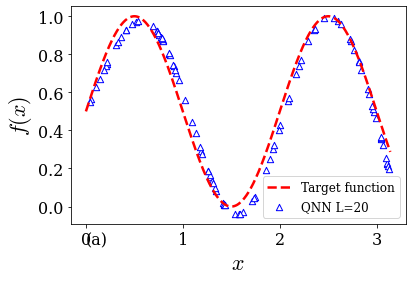

In [88]:
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["mathtext.fontset"] = "cm"

plt.plot(x_plot, y_plot, color="r", ls="--", lw=2.5, label="Target function")

plt.scatter(
        x_test,
        predict[0].numpy(),
        s=40,
        marker="^",
        facecolor="white",
        color="b",
        label="QNN L=20",
    )
plt.xlabel(r"$x$", fontdict={"size": 22})
plt.ylabel(r"$f(x)$", fontdict={"size": 22})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(prop={"size": 12})
plt.text(0, -0.2, r"(a)", fontsize=16)
plt.tick_params(labelsize=16)
plt.show()